<h3>Notebook for comparison of models</h3>
<br>
Please install pandas, numpy, matplotlib, tensorflow, xgboost and keras to run the whole notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Reading the dataset from csv files

In [2]:
df_orders = pd.read_csv("data/olist_orders_dataset.csv")
df_order_payments = pd.read_csv("data/olist_order_payments_dataset.csv")

Extracting the sales from the dataset.

In [4]:
# Joining the orders with payment records to connect
# the order timestamp(in olist_orders_dataset)
# and payment value(in olist_order_payments_dataset)
df_payments = df_orders.merge(df_order_payments, on='order_id', how='inner')[['order_purchase_timestamp', 'payment_value']]

#Extracting the date of the payments from the given time stamp.
df_payments['order_purchase_timestamp'] = pd.to_datetime(df_payments['order_purchase_timestamp'])
df_payments['order_purchase_timestamp'] = df_payments['order_purchase_timestamp'].dt.strftime('%Y/%m/%d')

#Sorting the payments according to the data.
df_payments = df_payments.sort_values(by='order_purchase_timestamp', ascending=True)

#Summing the orders on the same date.
df_payments = pd.DataFrame(df_payments.groupby('order_purchase_timestamp', as_index=False).agg(
    {'payment_value': 'sum'}))

#Removing the incomplete data from the tail and head of the time series.
mask = (df_payments['order_purchase_timestamp'] > '2017/01') & (df_payments['order_purchase_timestamp'] < '2018/08')
df_payments = df_payments.loc[mask]

# Calculation of Day of week(dow), month of year(moy) and day of month(dom)
df_payments['dow'] = pd.to_datetime(df_payments['order_purchase_timestamp']).apply(lambda x: x.dayofweek)
df_payments['moy'] = pd.to_datetime(df_payments['order_purchase_timestamp']).apply(lambda x: x.month)
df_payments['dom'] = pd.to_datetime(df_payments['order_purchase_timestamp']).apply(lambda x: x.day)

In [5]:
# Grouping the payments for multiple days(following code only group 
# the payments of one day and hence does not perform any operation) 
new_df_payments = df_payments.groupby(df_payments.index // 1).sum()
weekly_data_df = df_payments.groupby(df_payments.index // 1).sum()

Implementation of baseline method moving average

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'full') / w

Converting the data frames into numpy array to be able to feed the algorithms.

In [7]:
#Time seriese to predict
values = new_df_payments['payment_value'].to_numpy()

#Day of week
dow = new_df_payments['dow'].to_numpy()

#Month of year
moy = new_df_payments['moy'].to_numpy()

#day of month
dom = new_df_payments['dom'].to_numpy()

#Week of month calcultion
wom = [0]
last_month = moy[0]
for m, d in zip(moy[1:], dow[1:]):
    if m == last_month:
        if d != 0:
            wom.append(wom[-1])
        else:
            wom.append(wom[-1]+1)
    else:
        wom.append(0)
        last_month = m
wom = np.array(wom)

#Whether a weekend or not calculation. 
weekend = np.zeros(wom.shape)
weekend[np.where(dow == 5)] = 1
weekend[np.where(dow == 6)] = 1

Importing all the important libraries for the execution of of algorithms.

In [25]:
import xgboost
from sklearn.ensemble import RandomForestRegressor
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import regularizers

Defining and executing the models to compare them accross each other

Problem1 input window size 1, output window size 1
MAE % XGB      : 0.17785891101879592
MAE % RForest  : 0.18279637073353486
MAE % DNN      : 0.22598588172089606
MAE % LSTM     : 0.22194879033734594
MAE % MovingAVG: 0.23698532648689055

Problem2 input window size 7, output window size 7
MAE % XGB      : 0.19061478698511342
MAE % RForest  : 0.1920678974334664
MAE % DNN      : 0.1873982044493135
MAE % LSTM     : 0.18052266024155678
MAE % MovingAVG: 0.8531743063284598

Problem3 input window size 14, output window size 14
MAE % XGB      : 0.18303780005263517
MAE % RForest  : 0.1828809133786843
MAE % DNN      : 0.2790059562928508
MAE % LSTM     : 0.280264317522014
MAE % MovingAVG: 0.9245052377705982

Problem4 input window size 30, output window size 30
MAE % XGB      : 0.07591421853940974
MAE % RForest  : 0.06766968620855905
MAE % DNN      : 0.19999325701583304
MAE % LSTM     : 0.21674682899287256
MAE % MovingAVG: 0.9620528893653861



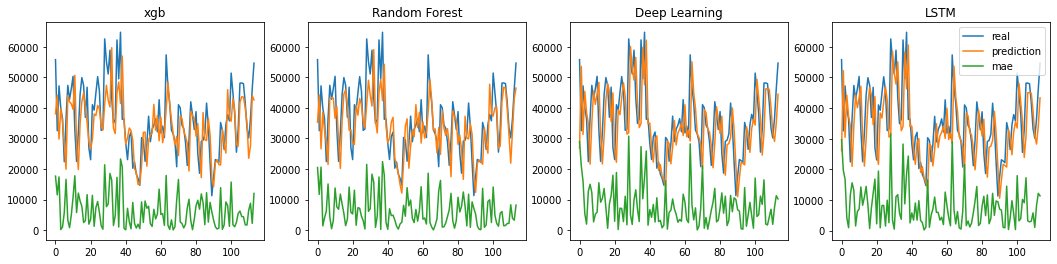

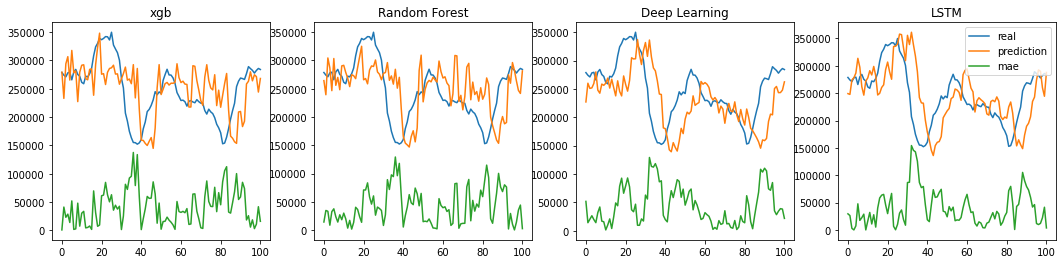

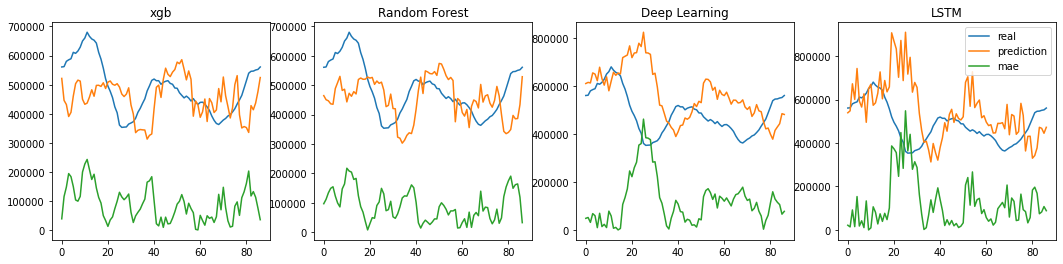

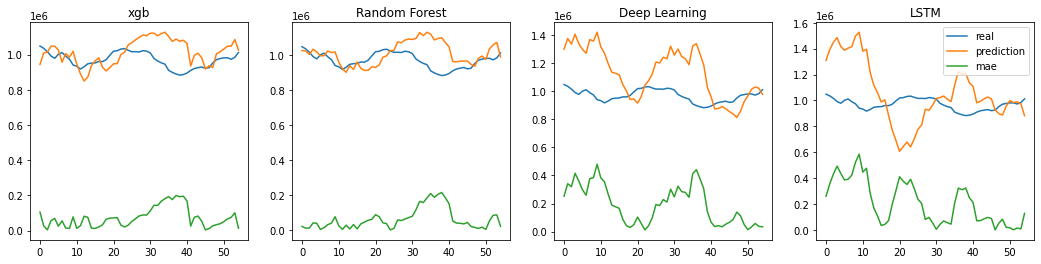

In [27]:
#LSTM Model declaration
def lstm_model(w, features):
    model = Sequential()
    model.add(LSTM(128, activation='relu',return_sequences=True, input_shape=(w, features)
                  ,go_backwards = True, recurrent_regularizer = regularizers.L1L2(l1=0.01, l2=0.01)))
    model.add(LSTM(64, activation='relu', return_sequences=False))
    model.add(Dense(32, activation='relu'))    
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

#DNN model declaration
def deep_learning(features):
    model = Sequential()
    model.add(Dense(64, input_shape=(features,), activation = 'linear'))
    model.add(Dense(8, activation='linear'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mse', optimizer= tf.keras.optimizers.Adam(learning_rate = 0.01), metrics=['mse','mae'])
    return model

#Formatting the data to be able to feed the LSTM Network. 
def format_data_for_lstm(x, w):
    data = x[:,:w]
    data = data.reshape((x.shape[0], w, 1))
    features = x[:,w:]
    features = features.reshape((features.shape[0], 1, features.shape[1]))
    features = np.repeat(features, w, axis=1)
    data = np.append(data, features, axis=2)
    return data

#The training testing and the plotting function.
def train_and_test(w, train_input, train_output, test_input, test_output, **kwargs):

#Initalizing the models.
    model1 = xgboost.XGBRFRegressor()
    model2 = RandomForestRegressor()
    model3 = deep_learning(train_input.shape[1])
    model4 = lstm_model(w, train_input.shape[1]-w+1)

#Fitting the models.
    model1.fit(train_input, train_output)
    model2.fit(train_input, train_output)
    model3.fit(train_input, train_output, epochs=100, batch_size=1, verbose=0)
    lstm_train_input = format_data_for_lstm(train_input, w)
    model4.fit(lstm_train_input, train_output, epochs=80, verbose=0)
    
#Testing the models
    xgb_pred = model1.predict(test_input)
    rf_pred = model2.predict(test_input)
    dl_pred = model3.predict(test_input)
    dl_pred = dl_pred.reshape(dl_pred.shape[0])
    lstm_test_input = format_data_for_lstm(test_input, w)
    lstm_pred = model4.predict(lstm_test_input)
    lstm_pred = lstm_pred.reshape(lstm_pred.shape[0])
    ma_pred = np.mean(test_input[:,:w], axis=1)

#Plotting the comparison graphs
    fig, axs = plt.subplots(1, 4, figsize=(18,4))
    axs[0].plot(range(test_output.shape[0]), test_output, label='real')
    axs[0].plot(range(xgb_pred.shape[0]), xgb_pred, label='prediction')
    axs[0].plot(range(xgb_pred.shape[0]), (abs(test_output-xgb_pred)), label='mae')
    axs[0].set_title('xgb')
    axs[1].plot(range(test_output.shape[0]), test_output, label='real')
    axs[1].plot(range(rf_pred.shape[0]), rf_pred, label='prediction')
    axs[1].plot(range(rf_pred.shape[0]), (abs(test_output-rf_pred)), label='mae')
    axs[1].set_title('Random Forest')
    axs[2].plot(range(test_output.shape[0]), test_output, label='real')
    axs[2].plot(range(dl_pred.shape[0]), dl_pred, label='prediction')
    axs[2].plot(range(dl_pred.shape[0]), (abs(test_output-dl_pred)), label='mae')
    axs[2].set_title('Deep Learning')
    axs[3].plot(range(test_output.shape[0]), test_output, label='real')
    axs[3].plot(range(lstm_pred.shape[0]), lstm_pred, label='prediction')
    axs[3].plot(range(lstm_pred.shape[0]), (abs(test_output-lstm_pred)), label='mae')
    axs[3].set_title('LSTM')
    plt.legend()
    
# Printing the MAE values for test predition of each model.
    print('MAE % XGB      : ' + str(np.mean(abs(test_output-xgb_pred)/test_output)))
    print('MAE % RForest  : ' + str(np.mean(abs(test_output-rf_pred)/test_output)))
    print('MAE % DNN      : ' + str(np.mean(abs(test_output-dl_pred)/test_output)))
    print('MAE % LSTM     : ' + str(np.mean(abs(test_output-lstm_pred)/test_output)))
    print('MAE % MovingAVG: ' + str(np.mean(abs(test_output-ma_pred)/test_output)))
    print()

# Function to create input data and run the experiments.
def create_data_and_train_test_model(w, split, values, dow, wom, weekend, cumilative_forcast_days, **kwargs):

# Splitting the data  features into train and test set.
    train_split_values = values[:int(values.shape[0]*split)]
    train_split_dow = dow[:int(values.shape[0]*split)]
    train_split_wom = wom[:int(values.shape[0]*split)]
    train_split_weekend = weekend[:int(values.shape[0]*split)]

    test_split_values = values[int(values.shape[0]*split):]
    test_split_dow = dow[int(values.shape[0]*split):]
    test_split_wom = wom[int(wom.shape[0]*split):]
    test_split_weekend = weekend[int(wom.shape[0]*split):]

# Combing all the required features into single data set. 
    def process_input(x,dow, wom, weekend, w):
        start = range(x.shape[0]-w)
        stop = range(w,x.shape[0])
        output = []
        for i, j in zip(start, stop):
            output.append(x[i:j])
        dow = dow[stop]
        wom = wom[stop]
        weekend = weekend[stop]
        output = np.array(output)
        output = np.append(output, dow.reshape(dow.shape[0],1), axis=1)
        output = np.append(output, wom.reshape(wom.shape[0],1), axis=1)
        output = np.append(output, weekend.reshape(weekend.shape[0],1), axis=1)
        return output

    # data for sigle day prediction
    oneday_train_input = process_input(
        train_split_values, train_split_dow,
        train_split_wom, train_split_weekend, w)
    oneday_test_input = process_input(
        test_split_values, test_split_dow,
        test_split_wom, test_split_weekend, w)
    oneday_train_output = train_split_values[w:]
    oneday_test_output = test_split_values[w:]


    if cumilative_forcast_days > 1:
# Cumilating the data for multiple days prediction.
        multi_day_train_input = oneday_train_input[:-cumilative_forcast_days]
        multi_day_test_input = oneday_test_input[:-cumilative_forcast_days]
        multi_day_train_output = np.zeros(oneday_train_output.shape[0]-cumilative_forcast_days)
        multi_day_test_output = np.zeros(oneday_test_output.shape[0]-cumilative_forcast_days)
        for i in range(cumilative_forcast_days):
            multi_day_train_output = multi_day_train_output + oneday_train_output[i:multi_day_train_output.shape[0]+i]
            multi_day_test_output = multi_day_test_output + oneday_test_output[i:multi_day_test_output.shape[0]+i]

        train_and_test(w, multi_day_train_input, multi_day_train_output,
                        multi_day_test_input, multi_day_test_output, **kwargs)
    else:
        train_and_test(w, oneday_train_input, oneday_train_output,
                        oneday_test_input, oneday_test_output, **kwargs)

# Ececution of experiments.
print('Problem1 input window size 1, output window size 1')
create_data_and_train_test_model(1, 0.8, values, dow, wom, weekend, 1)
print('Problem2 input window size 7, output window size 7')
create_data_and_train_test_model(7, 0.8, values, dow, wom, weekend, 7)
print('Problem3 input window size 14, output window size 14')
create_data_and_train_test_model(14, 0.8, values, dow, wom, weekend, 14)
print('Problem4 input window size 30, output window size 30')
create_data_and_train_test_model(30, 0.8, values, dow, wom, weekend, 30)
